### altimetry data processing 

In [1]:
import numpy as np
from glob import glob
import xarray as xr
from shapely import Point
import geopandas as gpd
import matplotlib.pyplot as plt
from utils.functions import meter2deg
from utils.functions import sample_from_raster


In [2]:
lake_name = 'dianchi'  
path_ht_spavar = f'data/{lake_name}-lake/swot-pixc/raster_height_spavar.nc'
path_lake_vec = f'data/{lake_name}-lake/hydrolake_{lake_name}_edit.gpkg'
paths_atl13 = sorted(glob(f'data/{lake_name}-lake/icesat2/ATL13/*.h5'))
path_atl13 = paths_atl13[0] 
path_atl13      ## check the selected ATL13 file


'data/dianchi-lake/icesat2/ATL13/106700352_ATL13_20230506123651_07051901_006_02_subsetted.h5'

In [3]:
## read vector file of the lake.
lake_gdf = gpd.read_file(path_lake_vec)
# ## read geoid correction file
raster_ht_spavar = xr.open_dataset(path_ht_spavar) 
## read ATL13 data
atl13_xr = xr.open_dataset(path_atl13, group='gt1r', engine='h5netcdf')
atl13_xr
# raster_ht_spavar


<xarray.Dataset> Size: 66kB
Dimensions:                        (delta_time: 165, ds_sseg_quality: 4)
Coordinates:
  * delta_time                     (delta_time) datetime64[ns] 1kB 2023-05-06...
    segment_lat                    (delta_time) float64 1kB ...
    segment_lon                    (delta_time) float64 1kB ...
Dimensions without coordinates: ds_sseg_quality
Data variables: (12/72)
    atl13refid                     (delta_time) float64 1kB ...
    bottom_lat                     (delta_time) float64 1kB ...
    bottom_lon                     (delta_time) float64 1kB ...
    cloud_flag_asr_atl09           (delta_time) float32 660B ...
    cloud_flag_atm_atl09           (delta_time) float32 660B ...
    cycle_number                   (delta_time) int8 165B ...
    ...                             ...
    sseg_start_lon                 (delta_time) float64 1kB ...
    stdev_water_surf               (delta_time) float32 660B ...
    subsurface_attenuation         (delta_time) float32 660B ...
    subsurface_backscat_ampltd     (delta_time) float32 660B ...
    transect_id                    (delta_time) float32 660B ...
    water_depth                    (delta_time) float32 660B ...
Attributes:
    Description:         Contains per-beam data products.
    atlas_beam_type:     weak
    atlas_pce:           pce1
    atlas_spot_number:   2
    atmosphere_profile:  profile_1
    data_rate:           Data within this group are stored at the inland wate...
    groundtrack_id:      gt1r
    sc_orientation:      Backward

In [4]:
# atl13_xr_b1 = xr.open_dataset(path_atl13, group='gt1l', engine='h5netcdf')
# atl13_xr_b2 = xr.open_dataset(path_atl13, group='gt2l', engine='h5netcdf')
# atl13_xr_b3 = xr.open_dataset(path_atl13, group='gt3l', engine='h5netcdf')
# atl13_xr = xr.concat([atl13_xr_b1, atl13_xr_b2, atl13_xr_b3], dim='delta_time')
# atl13_xr


In [5]:
## create a interior buffered lake vector
lake_decrease_gdf = lake_gdf.copy()
lon_center = lake_decrease_gdf.bounds.mean(axis=1).values
utm_zone = np.floor(lon_center/6)+31
epsg_code = f'326{int(utm_zone[0])}'
lake_decrease_gdf = lake_decrease_gdf.to_crs(epsg=epsg_code)
lake_decrease_gdf['geometry'] = lake_decrease_gdf.geometry.buffer(-1000)
lake_decrease_gdf = lake_decrease_gdf.to_crs(epsg=4326)
## select the data within the lake area
points = [Point(lon, lat) for lon, lat in zip(atl13_xr['segment_lon'].values, atl13_xr['segment_lat'].values)]
ids_valid_atl13 = np.where(lake_decrease_gdf.geometry[0].contains(points))[0]
atl13_xr_mask = atl13_xr.isel({'delta_time': ids_valid_atl13})
atl13_xr_mask


<xarray.Dataset> Size: 46kB
Dimensions:                        (delta_time: 115, ds_sseg_quality: 4)
Coordinates:
  * delta_time                     (delta_time) datetime64[ns] 920B 2023-05-0...
    segment_lat                    (delta_time) float64 920B 24.91 ... 24.76
    segment_lon                    (delta_time) float64 920B 102.7 ... 102.7
Dimensions without coordinates: ds_sseg_quality
Data variables: (12/72)
    atl13refid                     (delta_time) float64 920B ...
    bottom_lat                     (delta_time) float64 920B ...
    bottom_lon                     (delta_time) float64 920B ...
    cloud_flag_asr_atl09           (delta_time) float32 460B ...
    cloud_flag_atm_atl09           (delta_time) float32 460B ...
    cycle_number                   (delta_time) int8 115B ...
    ...                             ...
    sseg_start_lon                 (delta_time) float64 920B ...
    stdev_water_surf               (delta_time) float32 460B ...
    subsurface_attenuation         (delta_time) float32 460B ...
    subsurface_backscat_ampltd     (delta_time) float32 460B ...
    transect_id                    (delta_time) float32 460B ...
    water_depth                    (delta_time) float32 460B ...
Attributes:
    Description:         Contains per-beam data products.
    atlas_beam_type:     weak
    atlas_pce:           pce1
    atlas_spot_number:   2
    atmosphere_profile:  profile_1
    data_rate:           Data within this group are stored at the inland wate...
    groundtrack_id:      gt1r
    sc_orientation:      Backward

Text(0.5, 1.0, 'Corrected Geoid')

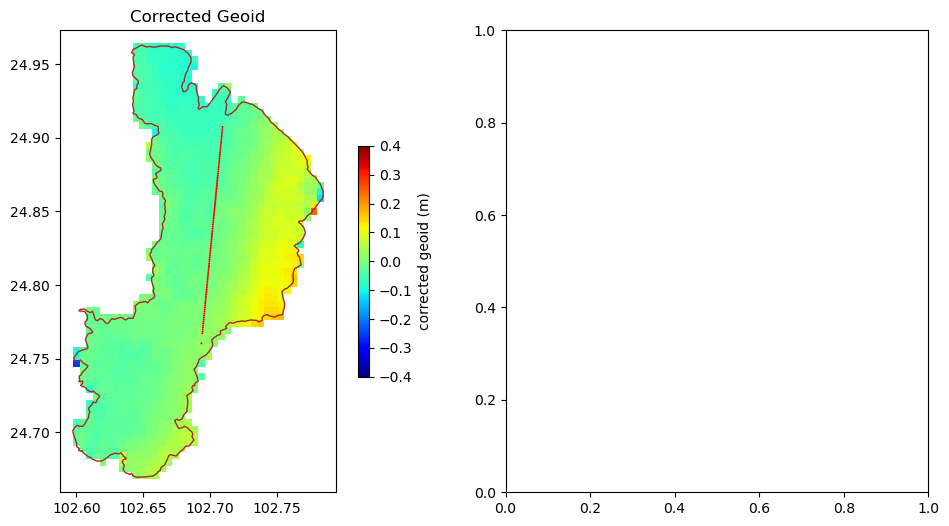

In [6]:
extent_raster = [raster_ht_spavar.x.min(), raster_ht_spavar.x.max(),
           raster_ht_spavar.y.min(), raster_ht_spavar.y.max()]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
## plot the smoothed spatial variation of lake surface height
img_show1 = ax[0].imshow(raster_ht_spavar.ht_spavar_smoothed.values, cmap='jet', 
                        vmin = -0.4, vmax = 0.4, extent=extent_raster)
lake_gdf.plot(ax=ax[0], edgecolor='Brown', facecolor='none', linewidth=1)
scat1 = ax[0].scatter(x=atl13_xr_mask.segment_lon, y=atl13_xr_mask.segment_lat, 
                      c='red', s=2, edgecolor='none')
plt.colorbar(img_show1, ax=ax[0], label='corrected geoid (m)', shrink=0.5)
ax[0].set_title('Corrected Geoid')
# ## plot the spatial variation of geoid height
# img_show2 = ax[1].imshow(raster_ht_spavar.geoid_spavar.values, cmap='jet', 
#                          vmin = -0.4, vmax = +0.4,
#                          extent=extent_raster)
# lake_gdf.plot(ax=ax[1], edgecolor='Brown', facecolor='none', linewidth=1)
# scat2 = ax[1].scatter(x=atl13_xr_mask.segment_lon, y=atl13_xr_mask.segment_lat,                       
#                       c='red', s=2, edgecolor='none')
# plt.colorbar(img_show2, ax=ax[1], label='HT Ortho (m)', shrink=0.5)
# ax[1].set_title('Geoid')



### apply the corrected geoid 

In [7]:
## Sample corrected geoid values at ATL13 points
atl13_ht_spavar = sample_from_raster(
        raster_value=raster_ht_spavar.ht_spavar_smoothed.values,
        raster_x = raster_ht_spavar.x.values,
        raster_y = raster_ht_spavar.y.values,
        points_x = atl13_xr_mask.segment_lon.values,
        points_y = atl13_xr_mask.segment_lat.values
        )
atl13_ht_spavar = atl13_ht_spavar - np.nanmean(atl13_ht_spavar)  ## remove the mean value
atl13_ht_ortho = atl13_xr_mask.ht_water_surf.values - atl13_xr_mask.segment_geoid.values  ## equal to atl13_xr.ht_ortho
atl13_geoid_cor = atl13_xr_mask.segment_geoid.mean().values + atl13_ht_spavar
atl13_ht_ortho_cor = atl13_xr_mask.ht_water_surf.values - atl13_geoid_cor


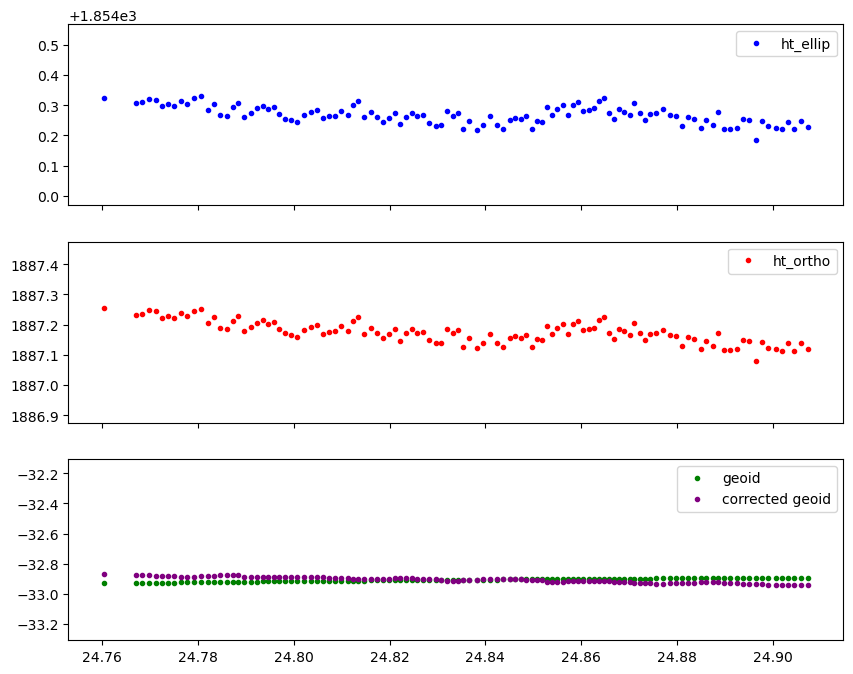

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
## plot height_ellip
ht_mean = np.mean(atl13_xr_mask.ht_water_surf.values)
ax[0].plot(atl13_xr_mask['segment_lat'], atl13_xr_mask.ht_water_surf.values, 
         marker='o', markersize=3, linestyle='None', 
         color='blue', label='ht_ellip')
ax[0].set_ylim(ht_mean - 0.3, ht_mean + 0.3)
ax[0].legend()
## plot height_ortho
ht_ortho_mean = np.nanmean(atl13_ht_ortho)
ax[1].plot(atl13_xr_mask['segment_lat'], atl13_ht_ortho, 
         marker='o', markersize=3, linestyle='None', 
         color='red', label='ht_ortho')
ax[1].set_ylim(ht_ortho_mean - 0.3, ht_ortho_mean + 0.3)
ax[1].legend()
## plot geoid
atl13_geoid_mean = np.nanmean(atl13_xr_mask.segment_geoid.values)
ax[2].plot(atl13_xr_mask['segment_lat'], atl13_xr_mask.segment_geoid.values, 
         marker='o', markersize=3, linestyle='None', 
         color='green', label='geoid')
ax[2].set_ylim(atl13_geoid_mean - 0.3, atl13_geoid_mean + 0.3)

atl13_geoid_cor_mean = np.nanmean(atl13_geoid_cor)
ax[2].plot(atl13_xr_mask['segment_lat'], atl13_geoid_cor,
         marker='o', markersize=3, linestyle='None', 
         color='purple', label='corrected geoid')
ax[2].set_ylim(atl13_geoid_cor_mean - 0.4, atl13_geoid_cor_mean + 0.8)
ax[2].legend()


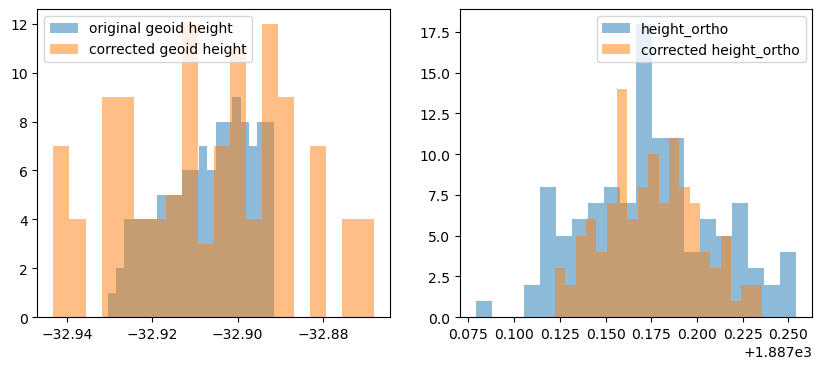

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(atl13_xr_mask.segment_geoid.values.ravel(), bins=20, alpha=0.5, label='original geoid height');
ax[0].hist(atl13_geoid_cor.ravel(), bins=20, alpha=0.5, label='corrected geoid height');
ax[0].legend();
ax[1].hist(atl13_ht_ortho, bins=20, alpha=0.5, label='height_ortho');
ax[1].hist(atl13_ht_ortho_cor, bins=20, alpha=0.5, label='corrected height_ortho');
ax[1].legend();


In [10]:
atl13_ht_ds = xr.Dataset({
  "geoid": (["delta_time"], atl13_xr_mask.segment_geoid.values),
  "geoid_cor": (["delta_time"], atl13_geoid_cor),  
  "ht_ortho": (["delta_time"], atl13_ht_ortho),
  "ht_ortho_cor": (["delta_time"], atl13_ht_ortho_cor)
}, coords={
  "delta_time": atl13_xr_mask["delta_time"],
  "segment_lon": atl13_xr_mask["segment_lon"],
  "segment_lat": atl13_xr_mask["segment_lat"]
})

path_save = path_atl13.replace('.h5', '_height.nc')
# atl13_ht_ds.to_netcdf(path_save)
atl13_ht_ds


<xarray.Dataset> Size: 6kB
Dimensions:       (delta_time: 115)
Coordinates:
  * delta_time    (delta_time) datetime64[ns] 920B 2023-05-06T13:17:25.898561...
    segment_lat   (delta_time) float64 920B 24.91 24.91 24.9 ... 24.77 24.76
    segment_lon   (delta_time) float64 920B 102.7 102.7 102.7 ... 102.7 102.7
Data variables:
    geoid         (delta_time) float32 460B -32.89 -32.89 ... -32.93 -32.93
    geoid_cor     (delta_time) float64 920B -32.94 -32.94 ... -32.87 -32.87
    ht_ortho      (delta_time) float32 460B 1.887e+03 1.887e+03 ... 1.887e+03
    ht_ortho_cor  (delta_time) float64 920B 1.887e+03 1.887e+03 ... 1.887e+03

In [11]:
print('std of geoid height:          ', np.nanstd(atl13_ht_ds['ht_ortho']))
print('std of geoid height corrected:', np.nanstd(atl13_ht_ds['ht_ortho_cor']))


std of geoid height:           0.035926882
std of geoid height corrected: 0.025489329911690322


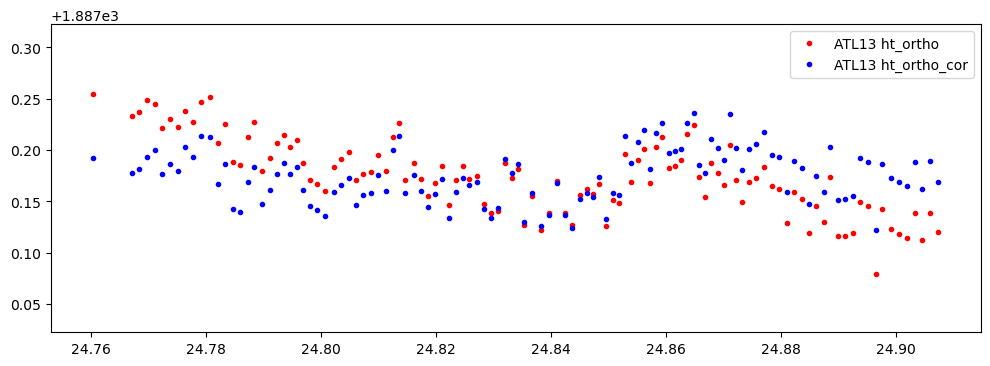

In [12]:
height_geoid_median = np.nanmedian(atl13_ht_ds['ht_ortho'])
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(atl13_xr_mask.segment_lat, atl13_ht_ds['ht_ortho'], 
                  marker='o', markersize=3, linestyle='None', 
                  color='red', label='ATL13 ht_ortho')

ax.plot(atl13_xr_mask.segment_lat, atl13_ht_ds['ht_ortho_cor'], 
                  marker='o', markersize=3, linestyle='None', 
                  color='blue', label='ATL13 ht_ortho_cor')
ax.set_ylim(height_geoid_median-0.15, height_geoid_median+0.15)
ax.legend()
